In [1]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import yfinance as yf
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflowjs as tfjs
import graphviz
import pydot
import time
from tensorflow.keras.utils import plot_model
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model Training

In [2]:
#global variables
stock_name = "AAPL"
stock_name_list = ["MSFT", "TSLA", "NVDA", "AAPL"]
start_year = 2014
end_year = 2024
day_before = 60
predict_day = 60
start_index = 0
start_date = '2014-01-01'
end_date = '2024-01-01'
sc = MinMaxScaler(feature_range=(0,1))
pwd = os.getcwd()

In [3]:
#common functions
def load_dataframe(**kwargs):
    stock_name = kwargs["stock_name"]
    start_date = kwargs["start_date"]
    end_date = kwargs["end_date"]
    df = yf.download(stock_name, start=start_date, end=end_date, progress=False)
    #df = pd.read_csv(f'./stocks/{name}.csv') # Default load local csv file
    return df

def get_X_train(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    day_before = kwargs["day_before"]
    end_index = len(df)
    X_train = df['Open'][start_index:end_index].values # open price
    X_train = sc.fit_transform(X_train.reshape(-1, 1))
    X_train = [X_train[i-day_before:i, 0] for i in range(day_before, len(X_train))]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train

def get_X_test(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    day_before = kwargs["day_before"]
    predict_day = kwargs["predict_day"]
    end_index = len(df)
    start_index = start_index - day_before - predict_day
    X_test = df['Open'][start_index:end_index].values # open price
    X_test = sc.fit_transform(X_test.reshape(-1, 1))
    X_test = [X_test[i-day_before:i, 0] for i in range(day_before, len(X_test))]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

def get_y_train(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    day_before = kwargs['day_before']
    end_index = len(df)
    y_train = df['Adj Close'][start_index:end_index].values # adjusted closing price
    y_train = sc.fit_transform(y_train.reshape(-1, 1))[0+day_before:end_index]
    return y_train

def get_y_test(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    predict_day = kwargs["predict_day"]
    start_index = start_index - predict_day
    end_index = len(df)
    y_test = df['Adj Close'][start_index:end_index].values # adjusted closing price
    return y_test

def save_model(**kwargs):
    model = kwargs["model"]
    stock_name = kwargs["stock_name"]
    model_dir = f"{pwd}\\model"
    path = f"{model_dir}\\{stock_name}\\{stock_name}.keras"
    if stock_name not in os.listdir(model_dir):
        os.mkdir(f"{model_dir}/{stock_name}")
    model.save(path)

def load_model(**kwargs):
    stock_name = kwargs["stock_name"]
    model_name = kwargs["model_name"]
    path = f"{pwd}\\model\\{stock_name}\\{model_name}"
    return tf.keras.models.load_model(path)

def convert_model_to_tfjs(**kwargs):
    stock_name = kwargs["stock_name"]
    #model = load_model(stock_name=stock_name)
    model = tf.keras.models.load_model(f"/content/model/{stock_name}/{stock_name}.keras")
    tfjs.converters.save_keras_model(model, f"/content/tfjs_model/{stock_name}")

In [4]:
#testing metrics functions
def root_mean_squared_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
    
def r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

def directional_accuracy(y_true, y_pred):
    correct_direction = np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])
    return np.mean(correct_direction) * 100

def get_all_metrics(y_true, y_pred):
    metrics_object = dict()
    metrics_object["mean_squared_error"] = mean_squared_error(y_true, y_pred)
    metrics_object["root_mean_squared_error"] = root_mean_squared_error(y_true, y_pred)
    metrics_object["mean_absolute_error"] = mean_absolute_error(y_true, y_pred)
    metrics_object["r_squared"] = r_squared(y_true, y_pred)
    metrics_object["directional_accuracy"] = directional_accuracy(y_true, y_pred)
    return metrics_object

In [5]:
def get_model(**kwargs):
    X_train = kwargs['X_train']
    y_train = kwargs['y_train']
    #numpy version require 1.19.5
    #!pip install numpy==1.19.5
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.1))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.1))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.1))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0)
    return model

def train_stock_prediction_model(**kwargs):
    #arguments
    stock_name = kwargs['stock_name']
    start_date = kwargs['start_date']
    end_date = kwargs['end_date']
    #logging
    print(f"Training {stock_name} stock prediction model")
    #load stock historical price data of certain stock code through yahoo finance library
    df = load_dataframe(stock_name=stock_name, start_date=start_date, end_date=end_date)
    #datafram size
    df_size = len(df)
    #split up training set
    X_train = get_X_train(df=df, start_index=start_index, day_before=day_before)
    y_train = get_y_train(df=df, start_index=start_index, day_before=day_before)
    #train model
    model = get_model(X_train=X_train, y_train=y_train)
    print(f"{stock_name} stock prediction model is trained")
    #saving the model
    save_model(model=model, stock_name=stock_name)
    #save_model(model=model, path=f"./model/{stock_name}")
    #return model if necessary for temporary debug
    return model

def train_set_of_stock_prediction_model(**kwargs):
    stock_name_list = kwargs['stock_name_list']
    start_date = kwargs['start_date']
    end_date = kwargs['end_date']
    model_list = []
    #iterate to train different stock prediction models
    for stock_name in stock_name_list:
        model_list.append(train_stock_prediction_model(stock_name=stock_name, start_date=start_date, end_date=end_date))
    return model_list

def plot_result(**kwargs):
    model = kwargs['model']
    stock_name = kwargs['stock_name']
    model_name = kwargs['model_name']
    predict_day = kwargs['predict_day']
    start_date = kwargs['start_date']
    end_date = kwargs['end_date']
    #load stock historical price data of certain stock code through yahoo finance library
    df = load_dataframe(stock_name=stock_name, start_date=start_date, end_date=end_date)
    #size of dataframe
    df_size = len(df)
    #testing set
    X_test = get_X_test(df=df, day_before=day_before, start_index=len(df), predict_day=predict_day)
    y_test = get_y_test(df=df, start_index=len(df), predict_day=predict_day)
    #Predicted stock price
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    #print(predicted_stock_price.shape)
    #Real stock price
    real_stock_price = y_test
    #print(real_stock_price.shape)
    # Visualising the results
    plt.figure(figsize=(16,6))
    plt.plot(df.index.values[df_size-predict_day:], real_stock_price, color = "red", label = f'Real {stock_name} Stock Price')
    plt.plot(df.index.values[df_size-predict_day:], predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{stock_name} Stock Price')
    plt.legend()
    #plt.savefig(f'./model/{stock_name}/{stock_name}.png')
    #plt.savefig(f'{pwd}\\graph\\{model_name}_{int(time.time())}.png')
    plt.savefig(f'{pwd}\\graph\\{model_name}.png')
    plt.show()
    show_testing_metrics(stock_name=stock_name, model_name=model_name, predicted_stock_price=predicted_stock_price, real_stock_price=real_stock_price)

def print_model_summary(**kwargs):
    model = kwargs['model']
    print(model.summary())
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=80,show_layer_names=True)

def show_testing_metrics(**kwargs):
    stock_name = kwargs['stock_name']
    model_name = kwargs['model_name']
    predicted_stock_price = kwargs['predicted_stock_price']
    real_stock_price = kwargs['real_stock_price']

    # Calculate metrics
    metrics_object = get_all_metrics(real_stock_price, predicted_stock_price)
    
    mse = metrics_object["mean_squared_error"]
    rmse = metrics_object["root_mean_squared_error"]
    mae = metrics_object["mean_absolute_error"]
    r2 = metrics_object["r_squared"]
    da = metrics_object["directional_accuracy"]

    result_string = f"""
    -----{stock_name} Testing Metrics-----
    Mean Squared Error (MSE): {mse}
    Root Mean Squared Error (RMSE): {rmse}
    Mean Absolute Error (MAE): {mae}
    R-squared (R²): {r2}
    Directional Accuracy: {da}
    """
    # Print results
    print(result_string)

    # Save logs
    #with open(f"{pwd}\\metric\\{model_name}.txt", "w") as file:
    #    file.write(result_string)
    #    file.close()

# Testing & Result evalution

In [6]:
def test_get_model(**kwargs):
    stock_name = kwargs["stock_name"]
    X_train = kwargs["X_train"]
    y_train = kwargs["y_train"]
    lstm_layer = kwargs["lstm_layer"]
    dense_layer = kwargs["dense_layer"]
    dropout = kwargs["dropout"]
    unit = kwargs["unit"]

    # declare model name for multiple model saving
    result_object = dict()
    model_name = f"{stock_name}_lstm_{lstm_layer}_dense_{dense_layer}_unit_{unit}"
    # log model name
    print(f"Compiling {model_name}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = unit, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.1))

    for i in range(lstm_layer):
        # Adding the LSTM layer and some Dropout regularisation iteratively
        model.add(LSTM(units = unit, return_sequences = True))
        model.add(Dropout(0.1))

    # Adding the last LSTM layer and some Dropout regularisation
    model.add(LSTM(units = unit))
    model.add(Dropout(0.1))

    for i in range(dense_layer):
    # Adding the Dense layer and some Dropout regularisation iteratively
        model.add(Dense(units = unit))
        model.add(Dropout(0.1))

    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0)
    # return model & model_name for further uses
    result_object["model_name"] = model_name
    result_object["model"] = model
    return result_object

def test_train_stock_prediction_model(**kwargs):
    #arguments
    stock_name = kwargs['stock_name']
    start_date = kwargs['start_date']
    end_date = kwargs['end_date']
    lstm_layers = kwargs['lstm_layers']
    dense_layers = kwargs['dense_layers']
    units = kwargs['units']
    dropouts = kwargs['dropouts']
    #logging
    print(f"Training {stock_name} stock prediction model")
    #load stock historical price data of certain stock code through yahoo finance library
    df = load_dataframe(stock_name=stock_name, start_date=start_date, end_date=end_date)
    #datafram size
    df_size = len(df)
    #split up training set
    X_train = get_X_train(df=df, start_index=start_index, day_before=day_before)
    y_train = get_y_train(df=df, start_index=start_index, day_before=day_before)
    #train model
    for lstm_layer in lstm_layers:
        for dense_layer in dense_layers:
            for dropout in dropouts:
                for unit in units:
                    start_time = time.time()
                    result_object = test_get_model(
                        stock_name=stock_name,
                        X_train=X_train,
                        y_train=y_train,
                        lstm_layer=lstm_layer,
                        dense_layer=dense_layer,
                        unit=unit,
                        dropout=dropout
                    )
                    model = result_object["model"]
                    model_name = result_object["model_name"]
                    end_time = time.time()
                    print(f"{model_name} Finished: {end_time - start_time}s")
                    #saving the model
                    test_save_model(model=model, stock_name=stock_name, model_name=model_name)

def test_save_model(**kwargs):
    model = kwargs["model"]
    stock_name = kwargs["stock_name"]
    model_name = kwargs["model_name"]
    model_dir = f"{pwd}\\model"
    path = f"{model_dir}\\{stock_name}\\{model_name}.keras"
    if stock_name not in os.listdir(model_dir):
        os.mkdir(f"{model_dir}/{stock_name}")
    model.save(path)

def get_comparison_object():
    # comparison between different models
    comparison_object = dict()
    comparison_object["mean_squared_error"] = dict()
    comparison_object["root_mean_squared_error"] = dict()
    comparison_object["mean_absolute_error"] = dict()
    comparison_object["r_squared"] = dict()
    comparison_object["directional_accuracy"] = dict()
    for key in comparison_object:
        val = 0
        if key == "r_squared" or key == "directional_accuracy":
            val = -math.inf
        else:
            val = math.inf
        comparison_object[key]["val"] = val
        comparison_object[key]["name"] = ""
    return comparison_object

def test_compare_models(**kwargs):
    #arguments
    stock_name = kwargs['stock_name']
    start_date = kwargs['start_date']
    end_date = kwargs['end_date']
    predict_day = kwargs['predict_day']
    df = load_dataframe(stock_name=stock_name, start_date=start_date, end_date=end_date)
    # size of dataframe
    df_size = len(df)
    # testing set
    X_test = get_X_test(df=df, day_before=day_before, start_index=len(df), predict_day=predict_day)
    y_test = get_y_test(df=df, start_index=len(df), predict_day=predict_day)
    #Real stock price
    real_stock_price = y_test

    path = f"{pwd}\\model\\{stock_name}"
    comparison_object = get_comparison_object()
    # load trained models
    for model_name in os.listdir(path):
        # only load *.keras model
        if ".keras" not in model_name:
            continue
        model = load_model(stock_name=stock_name, model_name=model_name)
        # predicted stock price
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        metrics_object = get_all_metrics(real_stock_price, predicted_stock_price)
        for metric in metrics_object:
            val = float(metrics_object[metric])
            if (metric == "r_squared" or metric == "directional_accuracy") and comparison_object[metric]['val'] < val:
                comparison_object[metric]['val'] = val
                comparison_object[metric]['name'] = model_name
            elif metric != "r_squared" and metric != "directional_accuracy" and comparison_object[metric]['val'] > val:
                comparison_object[metric]['val'] = val
                comparison_object[metric]['name'] = model_name

    for metric in comparison_object:
        print(f"({comparison_object[metric]['name']}) {metric}: {comparison_object[metric]['val']}")

In [17]:
def final_evaluation(**kwargs):
    #model = kwargs['model']
    day_before = 60
    model = kwargs['model']
    start_date = kwargs['start_date']
    end_date = kwargs['end_date']
    stock_name = kwargs['stock_name']
    X_test_df = load_dataframe(stock_name=stock_name, start_date='2023-01-01', end_date=end_date).reset_index()
    X_test_df['Date'] = X_test_df['Date'].apply(lambda x: str(x.date()))
    y_test_df = load_dataframe(stock_name=stock_name, start_date=start_date, end_date=end_date).reset_index()
    y_test_df['Date'] = y_test_df['Date'].apply(lambda x: str(x.date()))
    y_test_df_first_date = y_test_df.iloc[0]['Date']
    X_test_df_first_index = X_test_df[X_test_df['Date'] == y_test_df_first_date].index.values[0]
    predict_day = len(X_test_df) - X_test_df_first_index
    X_test_df = X_test_df.iloc[X_test_df_first_index - day_before:]
    X_test = get_X_test(df=X_test_df, start_index=len(X_test_df), day_before=day_before, predict_day=predict_day)
    df_size = len(X_test_df)
    
    index_arr = X_test_df['Date'][df_size-predict_day:].values
    real_stock_price = get_y_test(df=X_test_df, start_index=len(X_test_df), predict_day=predict_day)
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    # Plot graph
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(index_arr, real_stock_price, color='red', label="Real Stock Price")
    ax.plot(index_arr, predicted_stock_price, color='blue', label="Predicted Stock Price")
    ax.set_title(f'{stock_name} Stock Price Forecasting')
    ax.set_xlabel(f'Date')
    ax.set_ylabel(f'Price')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
    ax.legend()
    plt.show()
    fig.savefig(f'{pwd}\\graph\\{stock_name}_{start_date}_{end_date}.png', dpi=600, bbox_inches="tight")
    
    # Display evaluation metrics
    show_testing_metrics(
        stock_name=stock_name,
        model_name='',
        real_stock_price=real_stock_price,
        predicted_stock_price=predicted_stock_price,
    )

In [ ]:
# for stock_name in ['MSFT']:
#     test_train_stock_prediction_model(
#         stock_name=stock_name,
#         start_date=start_date,
#         end_date=end_date,
#         lstm_layers=[1,2],
#         dense_layers=[1,2],
#         units=[32,50,64,128],
#         dropouts=[0.1]
#     )

In [ ]:
for stock_name in ["MSFT", "TSLA", "AAPL", "NVDA"]:
    for i in [128]:
        model_name= f"{stock_name}_lstm_1_dense_2_unit_{i}.keras"
        test_model = load_model(stock_name=stock_name, model_name=model_name)
        final_evaluation(model=test_model, stock_name=stock_name, start_date='2024-01-01', end_date='2024-03-30')

In [ ]:
test_compare_models(stock_name="MSFT", start_date=start_date, end_date=end_date, predict_day=60)
test_compare_models(stock_name="AAPL", start_date=start_date, end_date=end_date, predict_day=60)
test_compare_models(stock_name="TSLA", start_date=start_date, end_date=end_date, predict_day=60)
test_compare_models(stock_name="NVDA", start_date=start_date, end_date=end_date, predict_day=60)

In [ ]:
test_compare_models(stock_name="MSFT", start_date=start_date, end_date=end_date, predict_day=120)
test_compare_models(stock_name="AAPL", start_date=start_date, end_date=end_date, predict_day=120)
test_compare_models(stock_name="TSLA", start_date=start_date, end_date=end_date, predict_day=120)
test_compare_models(stock_name="NVDA", start_date=start_date, end_date=end_date, predict_day=120)

In [ ]:
test_compare_models(stock_name="MSFT", start_date=start_date, end_date=end_date, predict_day=180)
test_compare_models(stock_name="AAPL", start_date=start_date, end_date=end_date, predict_day=180)
test_compare_models(stock_name="TSLA", start_date=start_date, end_date=end_date, predict_day=180)
test_compare_models(stock_name="NVDA", start_date=start_date, end_date=end_date, predict_day=180)

In [ ]:
test_compare_models(stock_name="MSFT", start_date=start_date, end_date=end_date, predict_day=40)
test_compare_models(stock_name="AAPL", start_date=start_date, end_date=end_date, predict_day=40)
test_compare_models(stock_name="TSLA", start_date=start_date, end_date=end_date, predict_day=40)
test_compare_models(stock_name="NVDA", start_date=start_date, end_date=end_date, predict_day=40)

In [8]:
def get_average_metrics(**kwargs):
    #arguments
    model_name = kwargs['model_name']
    path = f"{pwd}\\model\\"
    model_dict = dict()
    aggregate_obj = dict()
    metrics_list = []
    
    for stock_name in os.listdir(path):
        for model in os.listdir(path + stock_name):
            if model_name in model:
                model_dict[model] = load_model(stock_name=stock_name, model_name=model)
    
    for model_name in model_dict:
        model = model_dict[model_name]
        stock_name = model_name.split('_')[0]
        X_test_df = load_dataframe(stock_name=stock_name, start_date='2023-01-01', end_date='2024-03-30').reset_index()
        X_test_df['Date'] = X_test_df['Date'].apply(lambda x: str(x.date()))
        y_test_df = load_dataframe(stock_name=stock_name, start_date='2024-01-01', end_date='2024-03-30').reset_index()
        y_test_df['Date'] = y_test_df['Date'].apply(lambda x: str(x.date()))
        y_test_df_first_date = y_test_df.iloc[0]['Date']
        X_test_df_first_index = X_test_df[X_test_df['Date'] == y_test_df_first_date].index.values[0]
        predict_day = len(X_test_df) - X_test_df_first_index
        X_test_df = X_test_df.iloc[X_test_df_first_index - day_before:]
        X_test = get_X_test(df=X_test_df, start_index=len(X_test_df), day_before=day_before, predict_day=predict_day)
        df_size = len(X_test_df)

        index_arr = X_test_df['Date'][df_size-predict_day:].values
        real_stock_price = get_y_test(df=X_test_df, start_index=len(X_test_df), predict_day=predict_day)
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        
        metrics = get_all_metrics(real_stock_price, predicted_stock_price)
        metrics_list.append(metrics)
    
    total = len(metrics_list)

    for obj in metrics_list:
        for metric in obj:
            if metric not in aggregate_obj:
                aggregate_obj[metric] = 0
            aggregate_obj[metric] += obj[metric]
            
    for metric in aggregate_obj:
        aggregate_obj[metric] = aggregate_obj[metric] / total
    
    return aggregate_obj

In [12]:
def get_all_average_metrics():
    lstm_layers = [1,2]
    dense_layers = [1,2]
    units = [32, 50, 64, 128]
    for lstm_layer in lstm_layers:
        for dense_layer in dense_layers:
            for unit in units:
                model_name = f'lstm_{lstm_layer}_dense_{dense_layer}_unit_{unit}'
                print(model_name)
                metrics_obj = get_average_metrics(model_name=model_name)
                for metric in metrics_obj:
                    print(f'{metric}: {metrics_obj[metric]}')
                print()

In [13]:
get_all_average_metrics()

lstm_1_dense_1_unit_32
mean_squared_error: 290.6383564950179
root_mean_squared_error: 12.810394433154917
mean_absolute_error: 10.149803349229156
r_squared: 0.8093807247553774
directional_accuracy: 52.77777777777778

lstm_1_dense_1_unit_50
mean_squared_error: 313.0991408938177
root_mean_squared_error: 12.904492527132156
mean_absolute_error: 10.254700895215645
r_squared: 0.8369072259044557
directional_accuracy: 52.25

lstm_1_dense_1_unit_64
mean_squared_error: 264.29366330113487
root_mean_squared_error: 12.285853201438828
mean_absolute_error: 9.668940059474258
r_squared: 0.835377250219403
directional_accuracy: 52.45833333333333

lstm_1_dense_1_unit_128
mean_squared_error: 410.9268761300396
root_mean_squared_error: 14.430970627084035
mean_absolute_error: 11.53412621920226
r_squared: 0.828618620335778
directional_accuracy: 52.25

lstm_1_dense_2_unit_32
mean_squared_error: 521.6838811837359
root_mean_squared_error: 16.16750232038069
mean_absolute_error: 13.224977399482102
r_squared: 0.77524

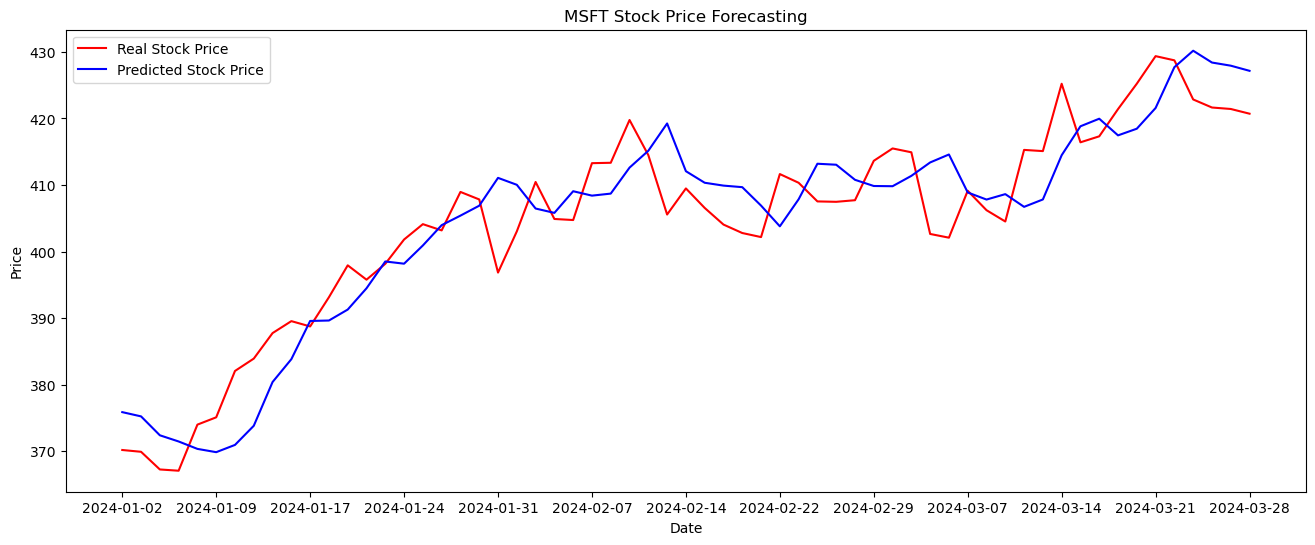


    -----MSFT Testing Metrics-----
    Mean Squared Error (MSE): 37.75875833563384
    Root Mean Squared Error (RMSE): 6.144815565632043
    Mean Absolute Error (MAE): 5.226137255058914
    R-squared (R²): 0.8368185994859006
    Directional Accuracy: 49.833333333333336
    


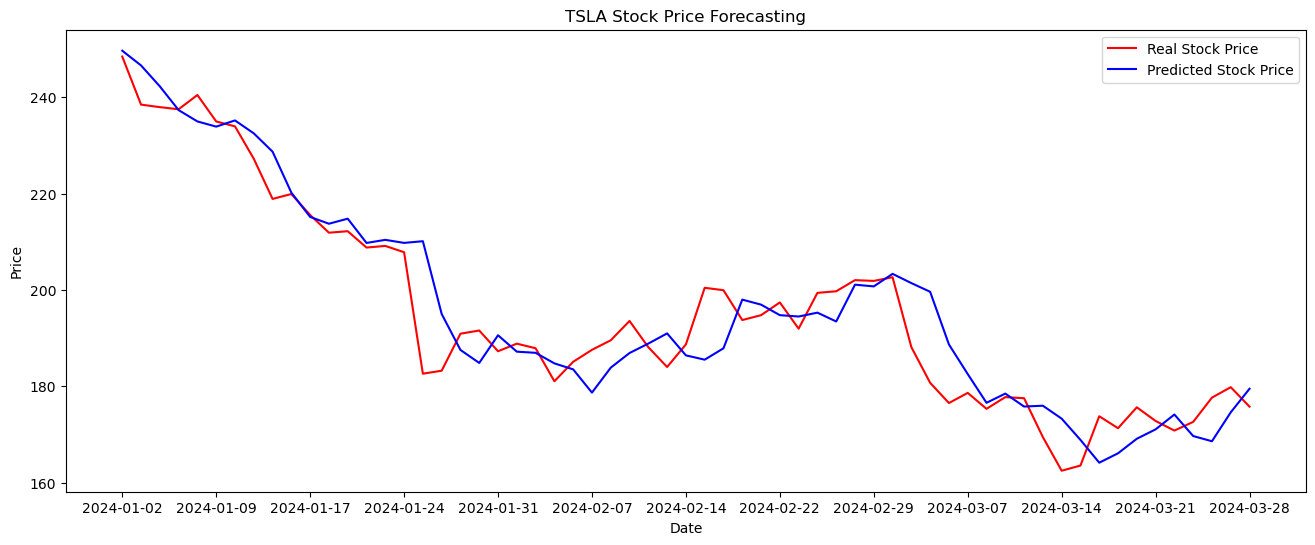


    -----TSLA Testing Metrics-----
    Mean Squared Error (MSE): 50.98381484944954
    Root Mean Squared Error (RMSE): 7.140295151424032
    Mean Absolute Error (MAE): 5.104877409387807
    R-squared (R²): 0.8851143916720273
    Directional Accuracy: 50.888888888888886
    


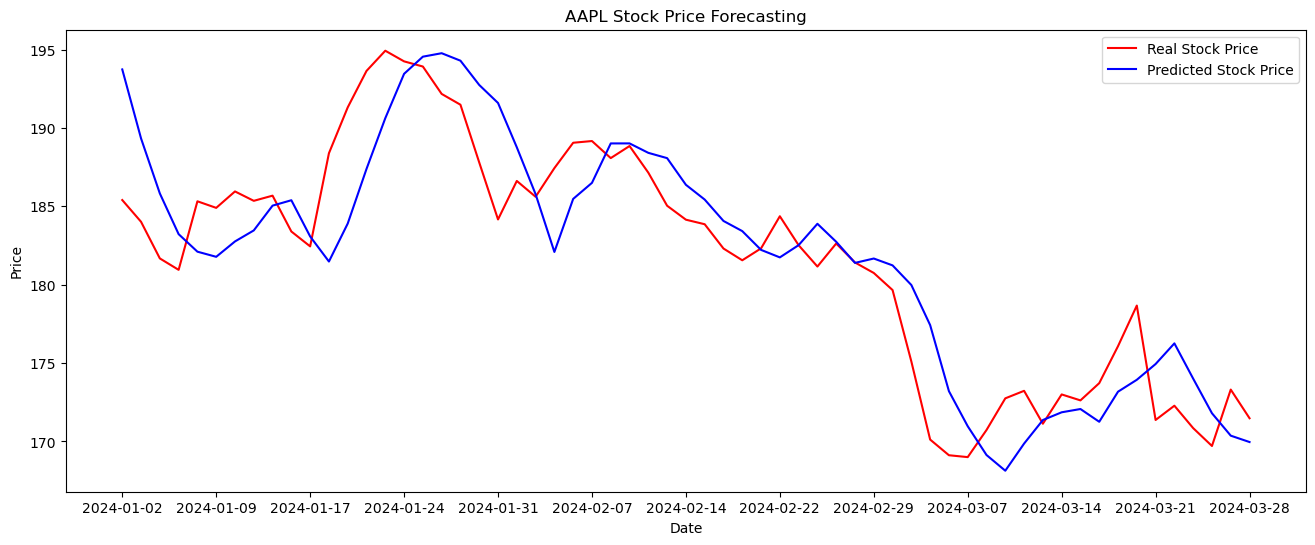


    -----AAPL Testing Metrics-----
    Mean Squared Error (MSE): 12.073469348064792
    Root Mean Squared Error (RMSE): 3.474689820410563
    Mean Absolute Error (MAE): 2.7997273929783555
    R-squared (R²): 0.7713132778333186
    Directional Accuracy: 51.66666666666667
    


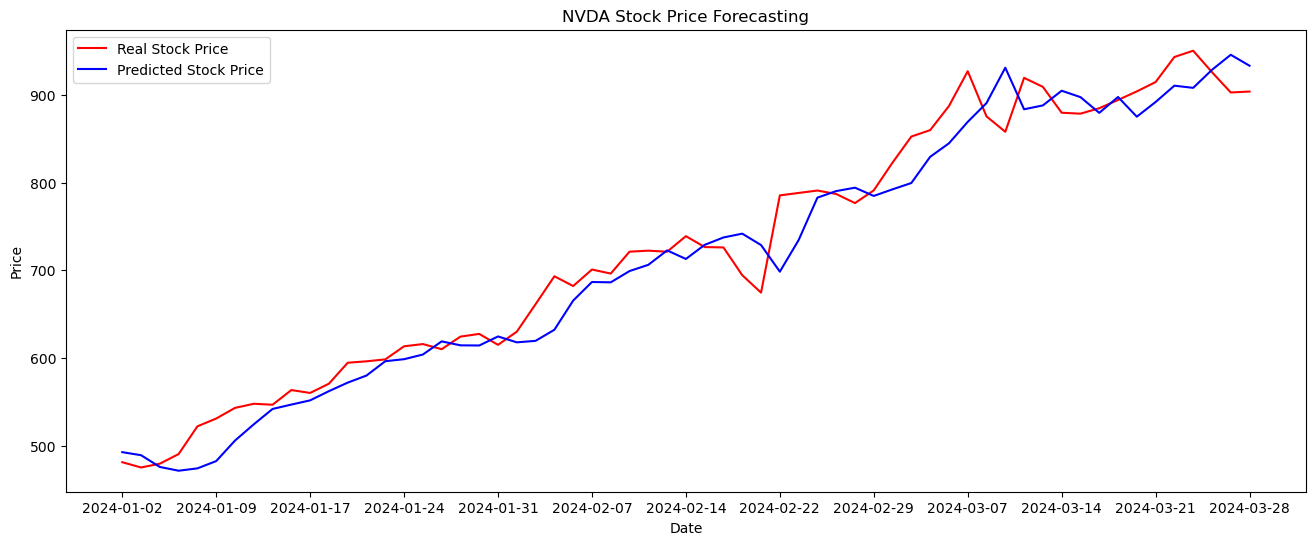


    -----NVDA Testing Metrics-----
    Mean Squared Error (MSE): 950.7794464021218
    Root Mean Squared Error (RMSE): 30.834711712648165
    Mean Absolute Error (MAE): 24.21551363585425
    R-squared (R²): 0.9533382566662861
    Directional Accuracy: 56.49999999999999
    


In [18]:
for stock_name in ["MSFT", "TSLA", "AAPL", "NVDA"]:
    for i in [128]:
        model_name= f"{stock_name}_lstm_1_dense_2_unit_{i}.keras"
        test_model = load_model(stock_name=stock_name, model_name=model_name)
        final_evaluation(model=test_model, stock_name=stock_name, start_date='2024-01-01', end_date='2024-03-30')

In [16]:
load_model(stock_name='AAPL', model_name='AAPL_lstm_1_dense_2_unit_128.keras').summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_31 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_22 (LSTM)              (None, 60, 128)           131584    
                                                                 
 dropout_32 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              